<center><img src="../img/UNCC_Logo.png"></center>

<center> <h1>Governor Effect on COVID-19 Progression
    </h1> </center>

<center> <h2>Final Project for Knowledge Discovery in Databases course (DSBA-6162) </h2><h2>at University of North Carolina at Charlotte (UNCC)
    </h2> </center>

### Team Members 
- Hari Chamlagai | https://github.com/chamlagaig
- James Mason | https://github.com/jkpm18
- Soumyadip Mitra | https://github.com/soumyadipmitra
- Phil Nguyen | https://github.com/gong-boy
- Ramya Prakash | https://github.com/RamyaPrakashPT

### Project Summary
<p>It has been several months since the COVID-19 pandemic began its rapid spread across the globe. There has been high variability in the types of responses taken by local and national leadership around the world in attempts to react to the virus with differing degrees of success. For this project we narrow our focus to the situation in the United States as we investigate the effect of the political parties of State Governors.</p>
	<p>On January 11, 2020, China announced its first novel coronavirus death, and on January 21 the United States declared its first confirmed case. By March 26 the United States had the most confirmed cases in the world. Thus, it is a worthwhile endeavour to explore some of the factors involved in the growth of the virus in the U.S. We use regression analysis to determine what relationships exist, if any, between two different dependent variables (state incident rate and state death rate) and a number of state-level features including state governor’s political party, governor’s sex, governor’s age at the date of the first confirmed U.S. case, governor’s time in office at the date of first U.S. case, state’s stay-at-home order response time, testing rate, population density, median household income, state GDP, and the percent of population that is in the high-risk age group (65+).</p>


### Research Question
What is the impact of the State Governor’s Political Party in addressing the Covid-19 pandemic?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.api import OLS
from statsmodels.api import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read in Data

# Johns Hopkins Data: Daily Cases
# https://github.com/CSSEGISandData/COVID-19
US_07_24 = pd.read_csv("../data/Johns_Hopkins_Data/Daily_Reports/07-24-2020_US.csv")

# Governors data
govn = pd.read_csv("../data/Other_Data/GOVERNORS.csv")

# US Census State Populations
pop = pd.read_csv("../data/Other_Data/CENSUS_State_Populations.csv")
pop = pop[["NAME", "POPESTIMATE2019"]]

# US Census State Area Measurements
areas = pd.read_csv("../data/Other_Data/CENSUS_StateAreaMeasurements.csv")
areas = areas[['State_and_Other_Areas', 'TotalArea_SqMi', 'LandArea_SqMi']]

# Median Household Income per State
hhi = pd.read_csv("../data/Other_Data/HH_Income.csv")

# State GDP
gdp = pd.read_csv("../data/Other_Data/State_GDP.csv")

# Stay-At-Home Order Dates
stay = pd.read_csv("../data/Other_Data/State_Stay_At_Home_Dates.csv")

# Population Distribution by Age
agedistrib = pd.read_csv("../data/Other_Data/Population_Distribution_by_Age.csv")

## I. Preprocessing

In [3]:
# Merge data sets
df01 = pd.merge(US_07_24, govn, how='inner', left_on = 'Province_State', right_on = 'State')
df02 = pd.merge(df01, pop, how='inner', left_on='Province_State', right_on='NAME')
df03 = pd.merge(df02, areas, how='inner', left_on='Province_State', right_on='State_and_Other_Areas')
df04 = pd.merge(df03, hhi, how='inner', left_on='Province_State', right_on='Location')
df05 = pd.merge(df04, gdp, how='inner', left_on='Province_State', right_on='State')
df06 = pd.merge(df05, stay, how='inner', left_on='Province_State', right_on='State')
df07 = pd.merge(df06, agedistrib, how='inner', left_on='Province_State', right_on='Location')

df = df07

In [4]:
# Calculate Deaths per Million
df["DeathsPerMillion"]=df.apply(lambda row: row["Deaths"]/(row["POPESTIMATE2019"]/1000000), axis=1)

# Calculate Confirmed Cases per Million
# NOTE: This is actually not needed because Incidence_Rate from the Johns Hopkins data set is cases/100K people
# df06["ConfirmedPerMillion"]=df06.apply(lambda row: row["Confirmed"]/(row["POPESTIMATE2019"]/1000000), axis=1)

# Calculate Population Density
df["Population_Density"]=df.apply(lambda row: row["POPESTIMATE2019"]/row["LandArea_SqMi"], axis=1)

In [5]:
# Convert data columns to dates
df["Last_Update_Converted"]=pd.to_datetime(df["Last_Update"])
df["DOB_Converted"]=pd.to_datetime(df["DOB"])
df["Inauguration_Date_Converted"]=pd.to_datetime(df["Inauguration_Date"])
df["SAHO_Effective_Date_Converted"]=pd.to_datetime(df["SAHO_Effective_Date"])

# Governor's Age (in YEARS) at time of first COVID-19 case in the U.S. (January 21, 2020)
df["Gov_Age_at_Onset"] = df.apply(lambda row: (pd.to_datetime("2020-01-21") - row["DOB_Converted"])/np.timedelta64(1,'Y'), axis=1)

# How long had Governor been in office (in MONTHS) at time of first COVID-19 case in the U.S. (January 21, 2020)
df["Gov_Tenure_at_Onset"] = df.apply(lambda row: (pd.to_datetime("2020-01-21") - row["Inauguration_Date_Converted"])/np.timedelta64(1,'M'), axis=1)

In [6]:
# IMPUTATION

# If a Stay-At-Home Order was never issued for a state, impute with the date of the Johns Hopkins snapshot. 
# This will effectively communicate that no order was issued
df["SAHO_Effective_Date_Converted"].replace(np.NaN, pd.to_datetime("2020-07-24"), inplace=True)

In [7]:
# Column containing number of days between first U.S. case and Stay-At-Home Order
df["SAHO_Response_Time"] = df.apply(lambda row: (row["SAHO_Effective_Date_Converted"] - pd.to_datetime("2020-01-21"))/np.timedelta64(1,'D'), axis=1)

In [8]:
# Log transform DeathsPerMillion because it is right skewed
df["log_DeathsPerMillion"] = np.log(df['DeathsPerMillion'])

In [9]:
# Print information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Province_State                 50 non-null     object        
 1   Country_Region                 50 non-null     object        
 2   Last_Update                    50 non-null     object        
 3   Lat                            50 non-null     float64       
 4   Long_                          50 non-null     float64       
 5   Confirmed                      50 non-null     int64         
 6   Deaths                         50 non-null     int64         
 7   Recovered                      44 non-null     float64       
 8   Active                         50 non-null     float64       
 9   FIPS                           50 non-null     int64         
 10  Incident_Rate                  50 non-null     float64       
 11  People_Tested        

In [10]:
# Export merged table to csv to investigate
df.to_csv("../data/Other_Data/FULL_TABLE.csv")

In [11]:
# Reduce width of dataframe by selecting desired columns
columns = ['Province_State', 'Confirmed', 'Deaths', 'Incident_Rate', 'DeathsPerMillion', 'log_DeathsPerMillion', 
           'People_Tested', 'Testing_Rate', 'Sex', 'Party', 'POPESTIMATE2019', 'TotalArea_SqMi', 'Med_HHI_thousands', 
           'GDP_Billions', 'Pct_65Plus', 'Population_Density', 'Gov_Age_at_Onset', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']

subset_prelim = df[columns]

In [12]:
subset_prelim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        50 non-null     object 
 1   Confirmed             50 non-null     int64  
 2   Deaths                50 non-null     int64  
 3   Incident_Rate         50 non-null     float64
 4   DeathsPerMillion      50 non-null     float64
 5   log_DeathsPerMillion  50 non-null     float64
 6   People_Tested         50 non-null     float64
 7   Testing_Rate          50 non-null     float64
 8   Sex                   50 non-null     object 
 9   Party                 50 non-null     object 
 10  POPESTIMATE2019       50 non-null     int64  
 11  TotalArea_SqMi        50 non-null     int64  
 12  Med_HHI_thousands     50 non-null     float64
 13  GDP_Billions          50 non-null     float64
 14  Pct_65Plus            50 non-null     int64  
 15  Population_Density    50 

In [13]:
# Transform categorical variables into dummy variables
subset = pd.get_dummies(subset_prelim)

## II. Exploratory Data Analysis

#### Look at dependent variable distributions

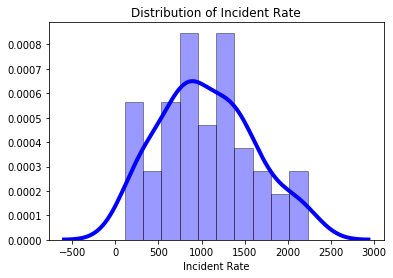

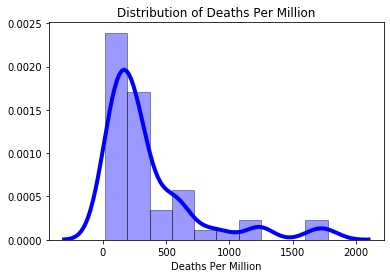

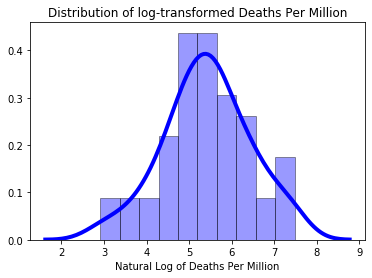

In [14]:
# Pick a handful of predictor variables and create histograms
cols = ['Incident_Rate', 'DeathsPerMillion', 'log_DeathsPerMillion']

title = ['Distribution of Incident Rate', 'Distribution of Deaths Per Million', 
         'Distribution of log-transformed Deaths Per Million']

xlab = ['Incident Rate', 'Deaths Per Million', 'Natural Log of Deaths Per Million']

for i in range(len(cols)):
    sns.distplot(subset[cols[i]], hist=True, kde=True, color = 'blue', bins=10,
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.title(title[i])
    plt.xlabel(xlab[i])
    plt.show()

DeathsPerMillion           AxesSubplot(0.125,0.125;0.227941x0.755)
Incident_Rate           AxesSubplot(0.398529,0.125;0.227941x0.755)
log_DeathsPerMillion    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object


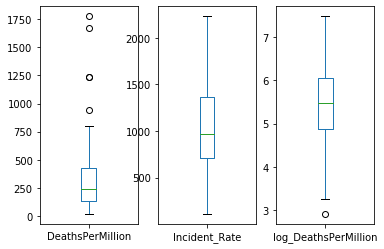

In [15]:
# Quick look at distributions of Dependent Variables

# print(subset_prelim[['Incident_Rate', 'DeathsPerMillion', 'log_DeathsPerMillion']].hist(layout=(1,3)))

print(subset_prelim[['DeathsPerMillion', 'Incident_Rate', 'log_DeathsPerMillion']].plot(kind='box', subplots=True))

#### Do Testing Rates, Incident Rates, and/or Death Rates differ by the political party of the governor?

AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)
AxesSubplot(0.1,0.15;0.8x0.75)


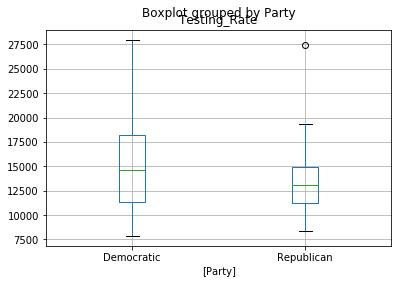

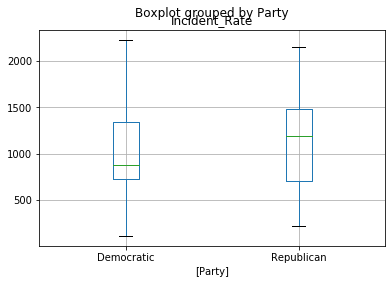

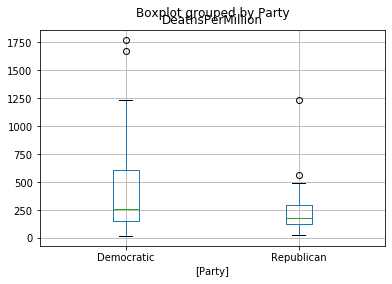

In [16]:
# Differences (if any) between governor political parties in terms of Testing Rate, Incident Rate, & Death Rate
print(subset_prelim[['Testing_Rate', 'Party']].boxplot(by='Party'))
print(subset_prelim[['Incident_Rate', 'Party']].boxplot(by='Party'))
print(subset_prelim[['DeathsPerMillion', 'Party']].boxplot(by='Party'))

#### Do Testing Rates, Incident Rates, and/or Death Rates differ by sex within political parties?

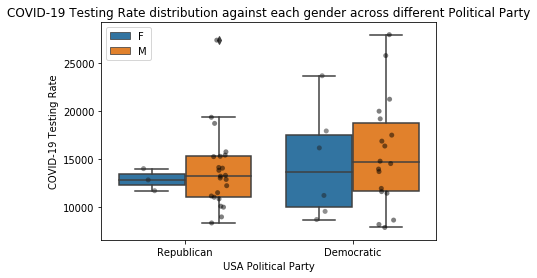

In [17]:
#Plotting Grouped Boxplot for COVID-19 Testing Rate distribution against each gender across different Political Party
bp = sns.boxplot(y='Testing_Rate', x='Party', data=subset_prelim, hue='Sex')

#Adding stripplot to above distribution
bp = sns.stripplot(y='Testing_Rate', x='Party', data=subset_prelim, jitter=True, dodge=True, 
                   marker='o', alpha=0.5, hue='Sex', color='Black' )


# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2])
plt.xlabel("USA Political Party")
plt.ylabel("COVID-19 Testing Rate")
plt.title("COVID-19 Testing Rate distribution against each gender across different Political Party")
plt.show()

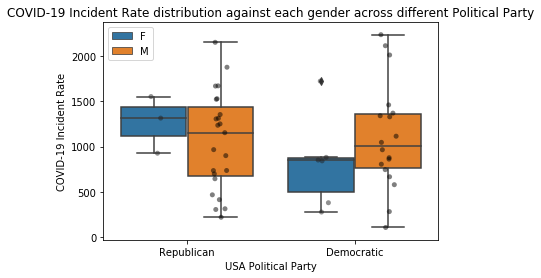

In [18]:
#Plotting Grouped Boxplot for COVID-19 Testing Rate distribution against each gender across different Political Party
bp = sns.boxplot(y='Incident_Rate', x='Party', data=subset_prelim, hue='Sex')

#Adding stripplot to above distribution
bp = sns.stripplot(y='Incident_Rate', x='Party', data=subset_prelim, jitter=True, dodge=True, 
                   marker='o', alpha=0.5, hue='Sex', color='Black' )


# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2])
plt.xlabel("USA Political Party")
plt.ylabel("COVID-19 Incident Rate")
plt.title("COVID-19 Incident Rate distribution against each gender across different Political Party")
plt.show()

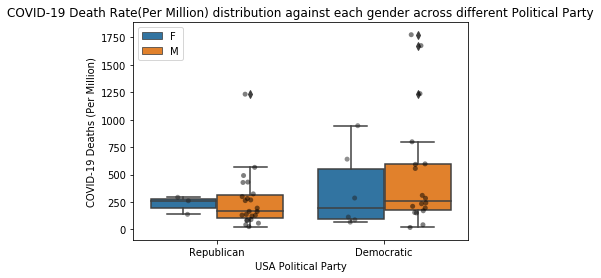

In [19]:
#Plotting Grouped boxlot for COVID-19 Death Rate(Per Million) distribution against each gender across different Political Party
bp = sns.boxplot(y='DeathsPerMillion', x='Party', data=subset_prelim, hue='Sex')

#Adding stripplot to above distribution
bp = sns.stripplot(y='DeathsPerMillion', x='Party', data=subset_prelim, jitter=True, dodge=True, 
                   marker='o', alpha=0.5, hue='Sex', color='Black' )


# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()
# specify just one legend
l = plt.legend(handles[0:2], labels[0:2])
plt.xlabel("USA Political Party")
plt.ylabel("COVID-19 Deaths (Per Million)")
plt.title("COVID-19 Death Rate(Per Million) distribution against each gender across different Political Party")
plt.show()

#### Scatterplot matrix

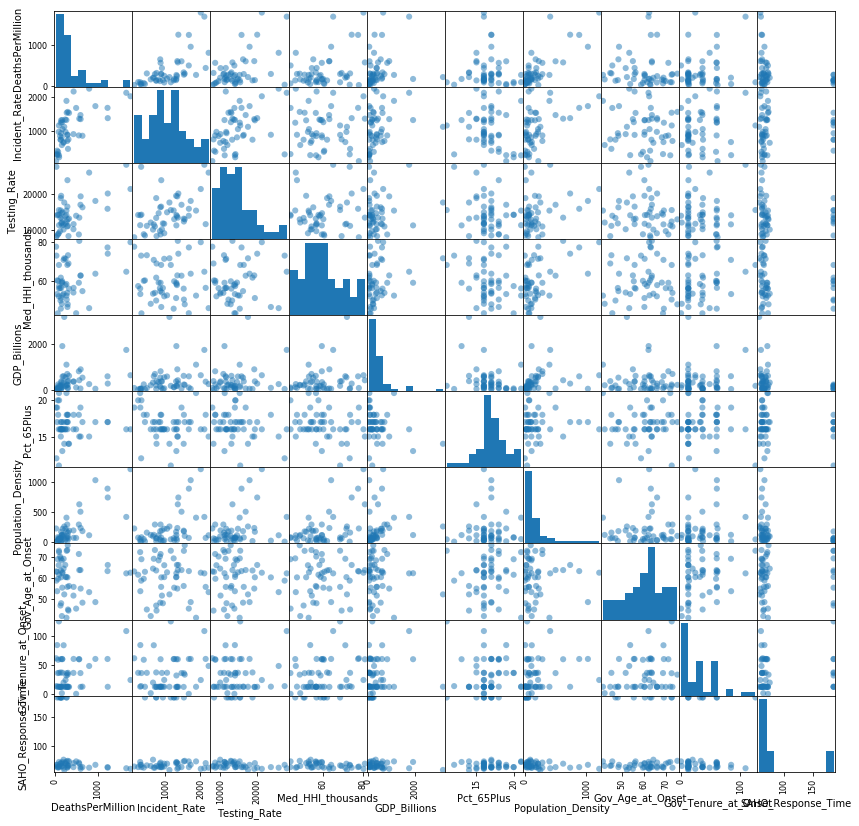

In [20]:
# Scatterplot Matrix to look at relationships between variables
pd.plotting.scatter_matrix(subset[['DeathsPerMillion', 'Incident_Rate', 'Testing_Rate', 'Med_HHI_thousands', 
                                   'GDP_Billions', 'Pct_65Plus', 'Population_Density', 'Gov_Age_at_Onset', 
                                   'Gov_Tenure_at_Onset', 'SAHO_Response_Time']],
                          figsize=[14,14], s=150)
plt.show()

#### Correlation Matrix

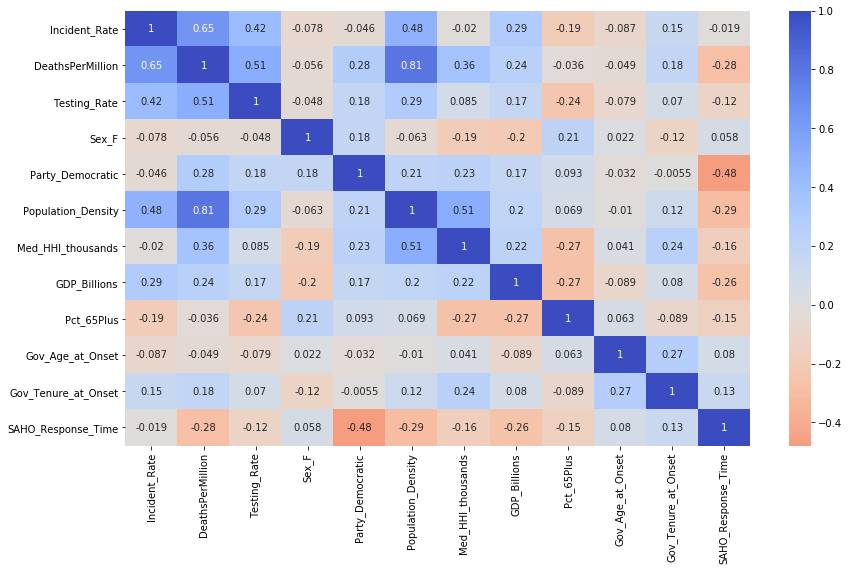

In [21]:
columns=['Incident_Rate','DeathsPerMillion', 'Testing_Rate', 'Sex_F', 'Party_Democratic', 
         'Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 'Pct_65Plus','Gov_Age_at_Onset', 
         'Gov_Tenure_at_Onset', 'SAHO_Response_Time']

subset_var = subset[columns]

#Generate a heatmap for the correlation matrix
plt.figure(figsize=(14,8))
sns.heatmap(subset_var.corr(),annot=True,cmap='coolwarm_r', center = 0)
plt.show()

#### Predictor variable distributions

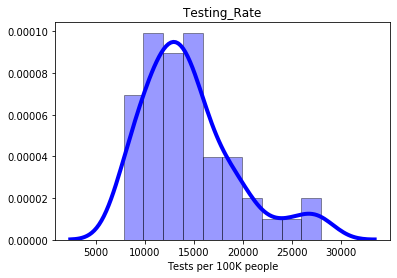

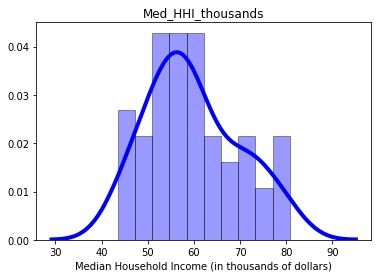

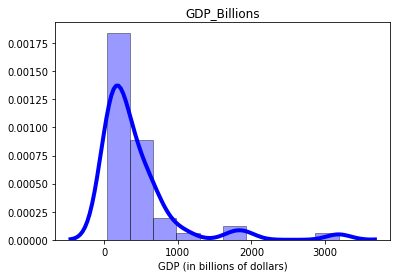

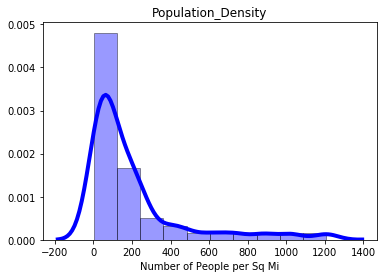

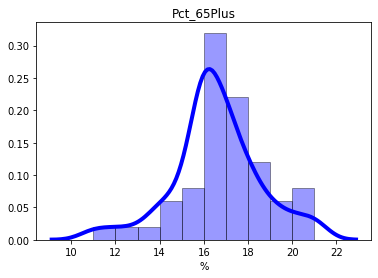

In [22]:
# Histograms for some predictor variables 
cols = ['Testing_Rate', 'Med_HHI_thousands', 
        'GDP_Billions', 'Population_Density', 'Pct_65Plus']
xlab = ['Tests per 100K people', 'Median Household Income (in thousands of dollars)', 
        'GDP (in billions of dollars)','Number of People per Sq Mi', '%']

for i in range(len(cols)):
    sns.distplot(subset[cols[i]], hist=True, kde=True, color = 'blue', bins=10,
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.title(cols[i])
    plt.xlabel(xlab[i])
    plt.show()

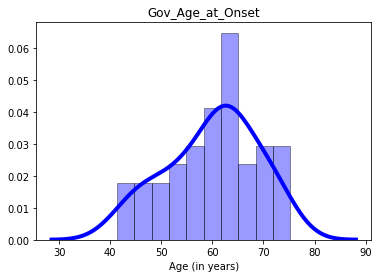

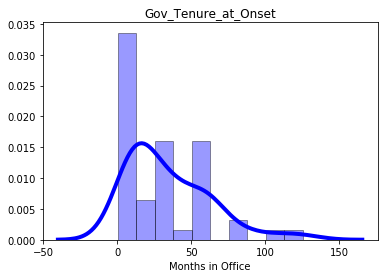

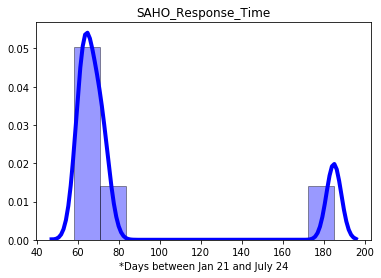

*Note: For SAHO_Response_Time, several states never issued stay-at-home orders,
    and for those states 07/24/2020 was used to fill in the missing dates.


In [23]:
# Histograms for the next group of variables 
cols = ['Gov_Age_at_Onset', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']
xlab = ['Age (in years)', 'Months in Office', '*Days between Jan 21 and July 24']

for i in range(len(cols)):
    sns.distplot(subset[cols[i]], hist=True, kde=True, color = 'blue', bins=10,
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.title(cols[i])
    plt.xlabel(xlab[i])
    plt.show()
    
print('*Note: For SAHO_Response_Time, several states never issued stay-at-home orders,')
print('    and for those states 07/24/2020 was used to fill in the missing dates.')

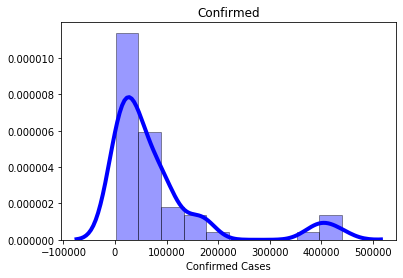

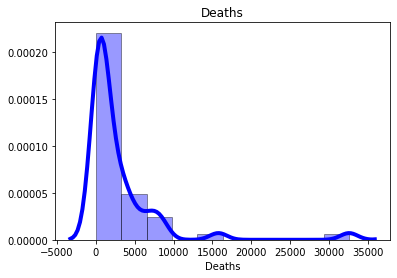

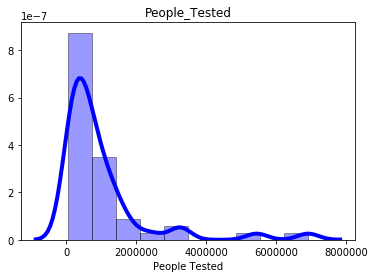

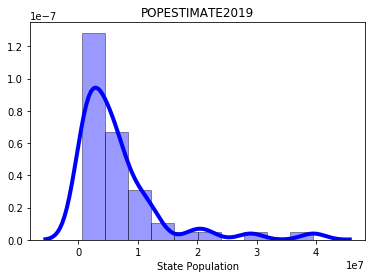

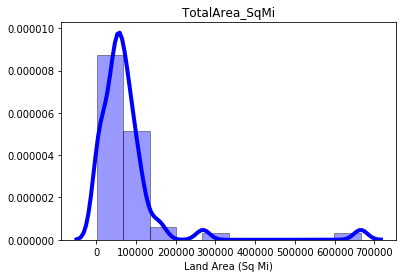

In [24]:
# Additional Predictors that were not used (example Confirmed was not used because Incident_Rate was)
cols = ['Confirmed', 'Deaths', 'People_Tested', 'POPESTIMATE2019', 'TotalArea_SqMi']
xlab = ['Confirmed Cases', 'Deaths', 'People Tested', 'State Population', 'Land Area (Sq Mi)']

for i in range(len(cols)):
    sns.distplot(subset[cols[i]], hist=True, kde=True, color = 'blue', bins=10,
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.title(cols[i])
    plt.xlabel(xlab[i])
    plt.show()

## III. Modeling

We will build two <b>Linear Regression</b> models. One with <i><b>Incident_Rate</b></i> as the dependent variable and one with <i><b>log_DeathsPerMillion</b></i> as the dependent variable.

The predictor variables to investigate are the following:
<ul>
    <li>Testing_Rate</li>
    <li>Sex</li>
    <li>Party</li>
    <li>Gov_Age_at_Onset</li>
    <li>Gov_Tenure_at_Onset</li>
    <li>SAHO_Response_Time</li>
    <li>Population_Density</li>
    <li>Med_HHI_thousands</li>
    <li>GDP_Billions</li>
    <li>Pct_65Plus</li>
</ul>

Prior to building our linear regression models, Lasso Regression was used for <b>feature selection</b> exploration.

### Preparation for Modeling

In [25]:
# Establish paired-down list of potential predictors
predictors = ['Testing_Rate', 'Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 
              'Pct_65Plus', 'Sex_F', 'Party_Democratic', 'Gov_Age_at_Onset', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']

In [26]:
# Separate predictor(X) and dependant(y) variabls for modeling purposes
X = subset[predictors]
y_m1 = subset['Incident_Rate']
y_m2 = subset['log_DeathsPerMillion']

In [27]:
# Calculate VIF to look for multicollinearity
# Resource: https://etav.github.io/python/vif_factor_python.html
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['featurs'] = X.columns
vif.round(1)

,VIF Factor,featurs
0,10.3,Testing_Rate
1,2.3,Population_Density
2,39.6,Med_HHI_thousands
3,1.9,GDP_Billions
4,39.5,Pct_65Plus
5,1.5,Sex_F
6,2.9,Party_Democratic
7,46.3,Gov_Age_at_Onset
8,3.0,Gov_Tenure_at_Onset
9,6.7,SAHO_Response_Time


### Feature Selection 

In [28]:
# Create a dataframe of all possible predictors to use for feature selection
X_fs=subset_prelim.drop(columns=['Incident_Rate', 'DeathsPerMillion', 'log_DeathsPerMillion', 'Province_State'])
X_fs = pd.get_dummies(X_fs, drop_first=True)

#### Feature Selection: Incident_Rate Model 

In [29]:
# Perform Lasso Regression on all possible predictors

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y_m1, train_size=0.80, random_state=44)

# Lasso Regression
reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)
print('')

# Print coefficients (Lasso regression will drive coefficients to zero for unimportant variables)
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",reg.coef_.transpose())
print(coef_table)
print('')

Lasso Regression: R^2 score on training set 82.97622734336156
Lasso Regression: R^2 score on test set 54.083834590796066

                      0       Coefs
0             Confirmed    0.009804
1                Deaths   -0.024342
2         People_Tested   -0.000399
3          Testing_Rate    0.041214
4       POPESTIMATE2019   -0.000125
5        TotalArea_SqMi   -0.002303
6     Med_HHI_thousands  -14.446415
7          GDP_Billions    1.115767
8            Pct_65Plus  -79.722179
9    Population_Density    0.556563
10     Gov_Age_at_Onset    2.885685
11  Gov_Tenure_at_Onset   -0.754413
12   SAHO_Response_Time   -0.041859
13                Sex_M  -76.015003
14     Party_Republican  117.445328



C:\Users\jkirk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 917405.2412731095, tolerance: 1071.553640182072
  positive)


According to the Lasso regression results above, the following variables all have coefficients with very small magnitude: <i>Confirmed, People_Tested, POPESTIMATE2019, and TotalArea_SqMi</i>. This supports our suspicion that variables which normalize for things like population size or land area (such as Testing_rate or Population_Density respectively) will be more useful than their raw-count versions. 

Now perform Lasso Regression on only the variables we want to use in the model.

In [30]:
# Perform Lasso Regression on our hand-chosen list of 10 predictor variables:
# ['Testing_Rate', 'Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 
#  'Pct_65Plus', 'Sex_F', 'Party_Democratic', 'Gov_Age_at_Onset', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']

# New Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_m1, train_size=0.70, random_state=44)

# Lasso Regression
reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)
print('')

# Print coefficients (Lasso regression will drive coefficients to zero for unimportant variables)
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",reg.coef_.transpose())
print(coef_table)
print('')

Lasso Regression: R^2 score on training set 58.82903821161914
Lasso Regression: R^2 score on test set 18.25222984537832

                     0       Coefs
0         Testing_Rate    0.020086
1   Population_Density    1.319673
2    Med_HHI_thousands  -23.921510
3         GDP_Billions    0.225223
4           Pct_65Plus   -2.914332
5                Sex_F    0.000000
6     Party_Democratic -342.376334
7     Gov_Age_at_Onset   -1.218175
8  Gov_Tenure_at_Onset    3.390058
9   SAHO_Response_Time   -0.056899



It appears that the sex of the governor is not an important variable when predicting Incident_Rate. However, we may keep it in the model to control for Sex while explaining governor effect.

#### Feature Selection: log_DeathsPerMillion Model

In [31]:
# Perform Lasso Regression on all possible predictors

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y_m2, train_size=0.80, random_state=44)

# Lasso Regression
reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)
print('')

# Print coefficients (Lasso regression will drive coefficients to zero for unimportant variables)
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",reg.coef_.transpose())
print(coef_table)
print('')

Lasso Regression: R^2 score on training set 78.37314181760611
Lasso Regression: R^2 score on test set 61.07685774218368

                      0         Coefs
0             Confirmed  1.723297e-06
1                Deaths  1.339216e-04
2         People_Tested -1.988847e-06
3          Testing_Rate  1.667337e-04
4       POPESTIMATE2019  1.422867e-07
5        TotalArea_SqMi -6.885588e-06
6     Med_HHI_thousands -0.000000e+00
7          GDP_Billions  1.898647e-03
8            Pct_65Plus -0.000000e+00
9    Population_Density  1.365087e-04
10     Gov_Age_at_Onset -1.067940e-02
11  Gov_Tenure_at_Onset -4.949551e-03
12   SAHO_Response_Time -0.000000e+00
13                Sex_M -0.000000e+00
14     Party_Republican  0.000000e+00



C:\Users\jkirk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2790740528472364, tolerance: 0.004036641517457808
  positive)


In [32]:
# Perform Lasso Regression on our hand-chosen list of 10 predictor variables:
# ['Testing_Rate', 'Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 
#  'Pct_65Plus', 'Sex_F', 'Party_Democratic', 'Gov_Age_at_Onset', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']

# New Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y_m2, train_size=0.70, random_state=44)

# Lasso Regression
reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)
print('')

# Print coefficients (Lasso regression will drive coefficients to zero for unimportant variables)
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",reg.coef_.transpose())
print(coef_table)
print('')

Lasso Regression: R^2 score on training set 53.01984582820847
Lasso Regression: R^2 score on test set 39.6718823933341

                     0     Coefs
0         Testing_Rate  0.000002
1   Population_Density  0.002617
2    Med_HHI_thousands -0.022928
3         GDP_Billions  0.000166
4           Pct_65Plus -0.000000
5                Sex_F  0.000000
6     Party_Democratic -0.000000
7     Gov_Age_at_Onset -0.000000
8  Gov_Tenure_at_Onset -0.002812
9   SAHO_Response_Time -0.001312



According to the Lasso Regression results, we should remove the following variables: <i>Pct_65Plus, Sex_F, Party_Democratic, & Gov_Age_at_Onset</i>.

### Model 1: Incident_Rate as dependent variable

#### Linear model with sklearn

In [33]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_m1, test_size = 0.2, random_state=44)

In [34]:
# Fit model using training data
lm = LinearRegression()
lm.fit(X_train,y_train)

y_pred_train = lm.predict(X_train)
y_pred = lm.predict(X_test)

cdf = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=["Coefficients"])

# n=X_train.shape[0]
# k=X_train.shape[1]
# dfN = n-k
# train_pred=lm.predict(X_train)
# train_error = np.square(train_pred - y_train)
# sum_error=np.sum(train_error)
# se=[0,0,0,0,0,0,0,0,0,0]
# for i in range(k):
#     r = (sum_error/dfN)
#     r = r/np.sum(np.square(X_train[list(X_train.columns)[i]]-X_train[list(X_train.columns)[i]].mean()))
#     se[i]=np.sqrt(r)
# cdf['Standard Error']=se
# cdf['t-statistic']=cdf['Coefficients']/cdf['Standard Error']


print('R-sq: ', r2_score(y_train, y_pred_train).round(3))
print("Intercept:", lm.intercept_.round(3))
print(cdf)
print('')
print('RMSE on train set: ', np.sqrt(mean_squared_error(y_train, y_pred_train)).round(3))
print('RMSE on test set:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

R-sq:  0.602
Intercept: 1766.131
                     Coefficients
Testing_Rate             0.022943
Population_Density       1.269875
Med_HHI_thousands      -23.269703
GDP_Billions             0.242320
Pct_65Plus              -2.136823
Sex_F                   39.772445
Party_Democratic      -307.507111
Gov_Age_at_Onset         0.227191
Gov_Tenure_at_Onset      3.656683
SAHO_Response_Time       0.361499

RMSE on train set:  326.541
RMSE on test set:   578.869


#### Linear model with statsmodels

In [35]:
# Use statsmodels and compare to results from sklearn

# References for using statsmodels: 
#  https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
#  https://datatofish.com/statsmodels-linear-regression/
#  https://stackoverflow.com/questions/54614157/scikit-learn-statsmodels-which-r-squared-is-correct


# In statsmodels we have to add a constant for it to be in the model
X_train_ = add_constant(X_train)

# Train model and print summary
result1 = OLS(y_train, X_train_).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Incident_Rate   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     4.386
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           0.000854
Time:                        14:53:13   Log-Likelihood:                -288.30
No. Observations:                  40   AIC:                             598.6
Df Residuals:                      29   BIC:                             617.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1766.1311   1088.547      1.622      0.116    -460.198    3992.460
Testing_Rate            0.0229      0.016      1.479      0.150      -0.009       0.055
Population_Density      1.2699      0.287      4.423      0.000       0.683       1.857
Med_HHI_thousands     -23.2697      8.287     -2.808      0.009     -40.219      -6.320
GDP_Billions            0.2423      0.115      2.103      0.044       0.007       0.478
Pct_65Plus             -2.1368     38.089     -0.056      0.956     -80.038      75.764
Sex_F                  39.7724    183.049      0.217      0.830    -334.604     414.149
Party_Democratic     -307.5071    153.006     -2.010      0.054    -620.440       5.426
Gov_Age_at_Onset        0.2272      7.449      0.030      0.976     -15.008      15.463
Gov_Tenure_at_Onset     3.6567      2.375      1.540      0.134      -1.201       8.514
SAHO_Response_Time      0.3615      1.657      0.218      0.829      -3.028       3.751
==============================================================================
Omnibus:                        4.530   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                3.210
Skew:                           0.554   Prob(JB):                        0.201
Kurtosis:                       3.836   Cond. No.                     2.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Remove variables and Rebuild Model
Do this one variable at a time, iteratively checking VIF and p-values after each removal. Start with Gov_Age_at_Onset because it has the highest VIF.

In [36]:
# Build a X dataframe of predictors taylored to the Incident_Rate model

# Removed Gov_Age_at_Onset, Pct_65Plus due to VIF
# Removed SAHO_Response_Time due to very high p-value
predictors_new = ['Testing_Rate', 'Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 
                  'Sex_F', 'Party_Democratic', 'Gov_Tenure_at_Onset']

X_m1 = subset[predictors_new]

In [37]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_m1, y_m1, test_size = 0.2, random_state=44)

In [38]:
# Recalculate VIF
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_m1.values, i) for i in range(X_m1.shape[1])]
vif['featurs'] = X_m1.columns
vif.round(1)

,VIF Factor,featurs
0,9.2,Testing_Rate
1,1.9,Population_Density
2,11.4,Med_HHI_thousands
3,1.8,GDP_Billions
4,1.3,Sex_F
5,2.2,Party_Democratic
6,2.8,Gov_Tenure_at_Onset


In [39]:
# Fit model using training data
lm = LinearRegression()
lm.fit(X_train,y_train)

y_pred_train = lm.predict(X_train)
y_pred = lm.predict(X_test)

print('R-sq: ', r2_score(y_train, y_pred_train).round(3))
print('')
print('RMSE on train set: ', np.sqrt(mean_squared_error(y_train, y_pred_train)).round(3))
print('RMSE on test set:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

R-sq:  0.601

RMSE on train set:  326.851
RMSE on test set:   586.717


In [40]:
# In statsmodels we have to add a constant for it to be in the model
X_train_ = add_constant(X_train)

# Train model and print summary
result1 = OLS(y_train, X_train_).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Incident_Rate   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     6.892
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           5.04e-05
Time:                        14:53:13   Log-Likelihood:                -288.34
No. Observations:                  40   AIC:                             592.7
Df Residuals:                      32   BIC:                             606.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1774.8299    447.418      3.967      0.000     863.469    2686.191
Testing_Rate            0.0232      0.014      1.676      0.104      -0.005       0.051
Population_Density      1.2522      0.255      4.910      0.000       0.733       1.772
Med_HHI_thousands     -23.2127      7.431     -3.124      0.004     -38.349      -8.077
GDP_Billions            0.2393      0.104      2.295      0.028       0.027       0.452
Sex_F                  42.3794    170.207      0.249      0.805    -304.321     389.080
Party_Democratic     -322.9571    129.307     -2.498      0.018    -586.348     -59.566
Gov_Tenure_at_Onset     3.8254      2.102      1.820      0.078      -0.455       8.106
==============================================================================
Omnibus:                        3.506   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.275
Skew:                           0.484   Prob(JB):                        0.321
Kurtosis:                       3.655   Cond. No.                     1.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Diagnostic plots

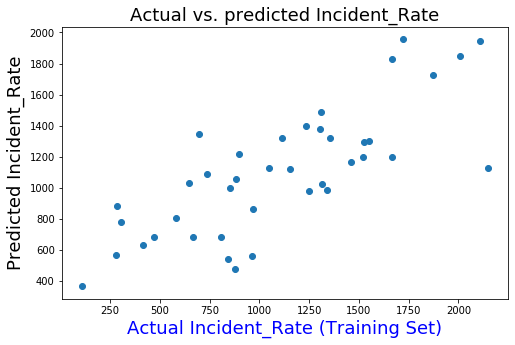

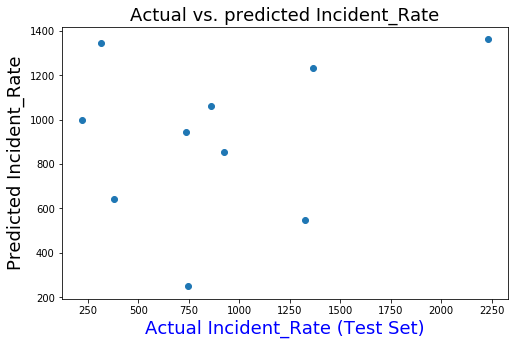

In [41]:
plt.figure(figsize=(8,5))
plt.title("Actual vs. predicted Incident_Rate",fontsize=18)
plt.xlabel("Actual Incident_Rate (Training Set)",fontsize=18, color="blue")
plt.ylabel("Predicted Incident_Rate", fontsize=18)
plt.scatter(x=y_train,y=y_pred_train)
plt.show()

plt.figure(figsize=(8,5))
plt.title("Actual vs. predicted Incident_Rate",fontsize=18)
plt.xlabel("Actual Incident_Rate (Test Set)",fontsize=18, color="blue")
plt.ylabel("Predicted Incident_Rate", fontsize=18)
plt.scatter(x=y_test,y=y_pred)
plt.show()

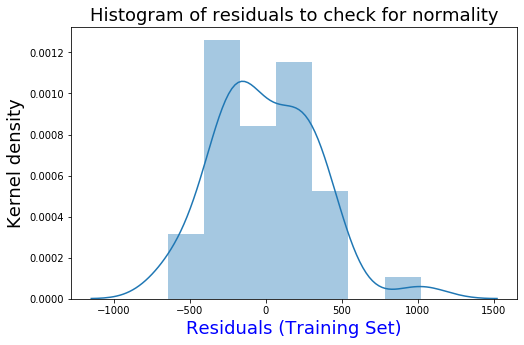

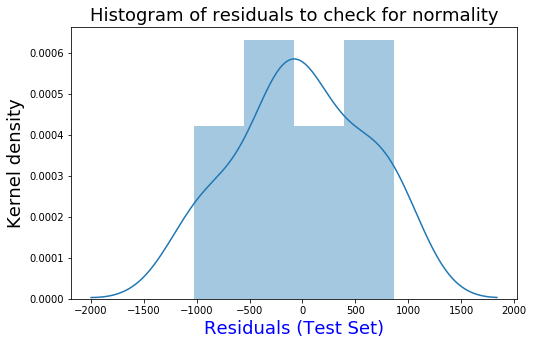

In [42]:
plt.figure(figsize=(8,5))
plt.title("Histogram of residuals to check for normality",fontsize=18)
plt.xlabel("Residuals (Training Set)",fontsize=18, color="blue")
plt.ylabel("Kernel density", fontsize=18)
sns.distplot([y_train-y_pred_train])
plt.show()

plt.figure(figsize=(8,5))
plt.title("Histogram of residuals to check for normality",fontsize=18)
plt.xlabel("Residuals (Test Set)",fontsize=18, color="blue")
plt.ylabel("Kernel density", fontsize=18)
sns.distplot([y_test-y_pred])
plt.show()

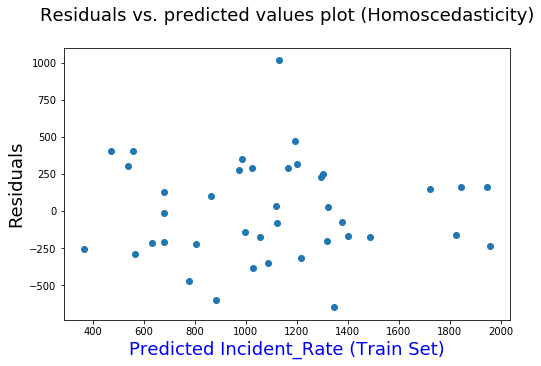

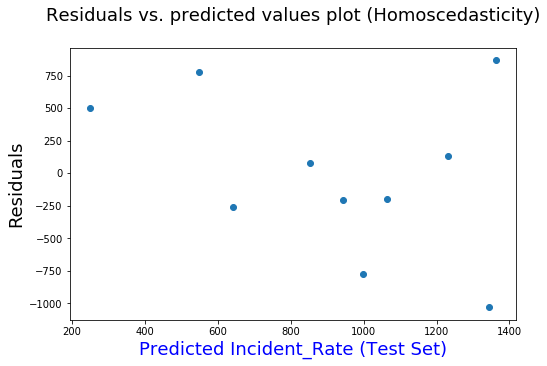

In [43]:
plt.figure(figsize=(8,5))
plt.title("Residuals vs. predicted values plot (Homoscedasticity)\n",fontsize=18)
plt.xlabel("Predicted Incident_Rate (Train Set)",fontsize=18, color="blue")
plt.ylabel("Residuals", fontsize=18)
plt.scatter(x=y_pred_train,y=y_train-y_pred_train)
plt.show()

plt.figure(figsize=(8,5))
plt.title("Residuals vs. predicted values plot (Homoscedasticity)\n",fontsize=18)
plt.xlabel("Predicted Incident_Rate (Test Set)",fontsize=18, color="blue")
plt.ylabel("Residuals", fontsize=18)
plt.scatter(x=y_pred,y=y_test-y_pred)
plt.show()

Residuals distribution is somewhat normal, and heterscedasticity assumption is not exceedingly violated.

### Run Model1 on entire data set (all 50 states)
Because we are interested in the direction of the coefficients and what they say about how a variable relates to Incidence_Rates, we look at the whole dataset.

#### TABLE 1: Incident_Rate Model Results (with OLS fit to all 50 states)

In [44]:
# In statsmodels we have to add a constant for it to be in the model
X_ = add_constant(X_m1)

# Train model and print summary
model = OLS(y_m1, X_)
result1 = model.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Incident_Rate   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     5.740
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           0.000106
Time:                        14:53:14   Log-Likelihood:                -368.24
No. Observations:                  50   AIC:                             752.5
Df Residuals:                      42   BIC:                             767.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1539.5944    470.076      3.275      0.002     590.943    2488.245
Testing_Rate            0.0302      0.013      2.275      0.028       0.003       0.057
Population_Density      1.1482      0.273      4.207      0.000       0.597       1.699
Med_HHI_thousands     -20.8971      7.522     -2.778      0.008     -36.077      -5.717
GDP_Billions            0.2235      0.114      1.965      0.056      -0.006       0.453
Sex_F                 -17.3270    164.853     -0.105      0.917    -350.014     315.360
Party_Democratic     -173.1897    128.310     -1.350      0.184    -432.130      85.750
Gov_Tenure_at_Onset     2.6515      2.219      1.195      0.239      -1.826       7.129
==============================================================================
Omnibus:                        1.871   Durbin-Watson:                   2.413
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.019
Skew:                           0.201   Prob(JB):                        0.601
Kurtosis:                       3.572   Cond. No.                     1.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

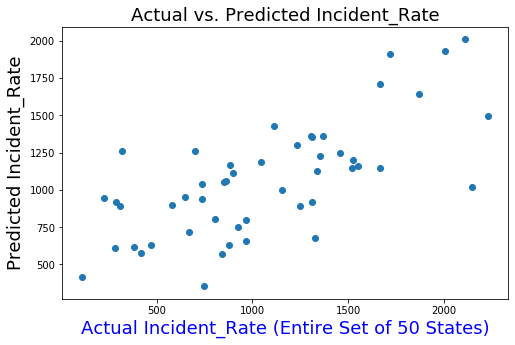

In [45]:
pred_m1 = result1.predict(X_)

plt.figure(figsize=(8,5))
plt.title("Actual vs. Predicted Incident_Rate",fontsize=18)
plt.xlabel("Actual Incident_Rate (Entire Set of 50 States)",fontsize=18, color="blue")
plt.ylabel("Predicted Incident_Rate", fontsize=18)
plt.scatter(x=y_m1,y=pred_m1)
plt.show()

#### Model 1 Interpretation:

<p>The first model (Model 1) used Incident_Rate (cases per 100K people) as the dependent variable. After selecting appropriate variables, the model was trained on 80% of the data (40 states) and tested on 20% (10 states) to get an idea of how well the model fit the data. The training RMSE (326.85) was much lower than than the test RMSE (586.72) indicating a possible problem with overfitting. The adjusted R-sq for the training data fit was .514 which indicates the variables explain about 51% of the variance in incident rate. Using the same seven variables, a new model was fit to all 50 states because we were interested in the nature of the relationships between predictors and incident rates across the entire U.S. The results are shown above in Table 1. Adjusted R-sq was .404, indicating the variables actually only explain about 40% of the variability when looking at all 50 states. Looking at the p-values, Sex_F is very clearly not statistically significant at any reasonable confidence level when predicting Incident Rate, but it was kept in the model as a control variable. Party_Democratic and Gov_Tenure_at_Onset have slightly high p-values, but they would both be significant at a 25% confidence level (which is admittedly lenient).</p>

<p>The coefficients from Model 1 provide interesting insights. Testing_Rate has a positive coefficient, indicating that for every additional test per 100,000 people we only expect an increase in Incident_Rate of 0.03. So while more testing does result in more positive cases, incident rate does not seem to increase as fast as the testing rate. The positive coefficient on Population_Density matches our intuition that more densely populated areas correspond to an increase in the number of positive cases. Conversely, a higher median household income for a state corresponds to a lower incident rate. It is interesting that higher GDPs correspond to higher incident rates. We will not interpret the coefficient on Sex_F because the p-value is .917. Party_Democratic seems to be associated with a lower incident rate. In fact this variable has the largest magnitude of all the variables in this model. And Gov_Tenure_at_Onset has a positive coefficient, but we will not interpret this coefficient because the variable has the second highest p-value. We are treating this variable as another control variable.</p>

<<<<<<<<<<<<<<<<<<<<<<<<<< END MODEL 1 >>>>>>>>>>>>>>>>>>>>>>>>>>>>

### Model 2: log_DeathsPerMillion

#### Initial Model with all potential variables

In [46]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_m2, test_size = 0.2, random_state=44)

In [47]:
# Fit model using training data
lm = LinearRegression()
lm.fit(X_train,y_train)

y_pred_train = lm.predict(X_train)
y_pred = lm.predict(X_test)

cdf = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=["Coefficients"])

print('R-sq: ', r2_score(y_train, y_pred_train).round(3))
print("Intercept:", lm.intercept_.round(3))
print(cdf)
print('')
print('RMSE on train set: ', np.sqrt(mean_squared_error(y_train, y_pred_train)).round(3))
print('RMSE on test set:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

R-sq:  0.571
Intercept: 7.117
                     Coefficients
Testing_Rate             0.000023
Population_Density       0.002646
Med_HHI_thousands       -0.029716
GDP_Billions             0.000310
Pct_65Plus              -0.012603
Sex_F                    0.340814
Party_Democratic        -0.219338
Gov_Age_at_Onset        -0.010375
Gov_Tenure_at_Onset      0.002894
SAHO_Response_Time      -0.002273

RMSE on train set:  0.658
RMSE on test set:   0.867


In [48]:
# In statsmodels we have to add a constant for it to be in the model
X_train_ = add_constant(X_train)

# Train model and print summary
result1 = OLS(y_train, X_train_).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_DeathsPerMillion   R-squared:                       0.571
Model:                              OLS   Adj. R-squared:                  0.424
Method:                   Least Squares   F-statistic:                     3.866
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):            0.00208
Time:                          14:53:14   Log-Likelihood:                -39.996
No. Observations:                    40   AIC:                             102.0
Df Residuals:                        29   BIC:                             120.6
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.1168      2.192      3.246      0.003       2.633      11.601
Testing_Rate         2.267e-05   3.12e-05      0.726      0.474   -4.12e-05    8.66e-05
Population_Density      0.0026      0.001      4.577      0.000       0.001       0.004
Med_HHI_thousands      -0.0297      0.017     -1.780      0.085      -0.064       0.004
GDP_Billions            0.0003      0.000      1.334      0.193      -0.000       0.001
Pct_65Plus             -0.0126      0.077     -0.164      0.871      -0.170       0.144
Sex_F                   0.3408      0.369      0.924      0.363      -0.413       1.095
Party_Democratic       -0.2193      0.308     -0.712      0.482      -0.850       0.411
Gov_Age_at_Onset       -0.0104      0.015     -0.691      0.495      -0.041       0.020
Gov_Tenure_at_Onset     0.0029      0.005      0.605      0.550      -0.007       0.013
SAHO_Response_Time     -0.0023      0.003     -0.681      0.501      -0.009       0.005
==============================================================================
Omnibus:                        2.527   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.335
Skew:                          -0.562   Prob(JB):                        0.311
Kurtosis:                       2.626   Cond. No.                     2.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Refine the model

In [49]:
# Build a X dataframe of predictors taylored to the log_DeathsPerMillion model

# Removed Gov_Age_at_Onset and Pct_65Plus due to high VIF. Also they were not statistically significant.
# Removed SAHO_Response_Time due to high p-value. Also this is the one column that was imputed, so not as trusted.
predictors_new = ['Testing_Rate', 'Population_Density', 'Med_HHI_thousands', 'GDP_Billions',
                  'Sex_F', 'Party_Democratic', 'Gov_Tenure_at_Onset']

X_m2 = subset[predictors_new]

In [50]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_m2, y_m2, test_size = 0.2, random_state=44)

In [51]:
# Recalculate VIF
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_m2.values, i) for i in range(X_m2.shape[1])]
vif['featurs'] = X_m2.columns
vif.round(1)

,VIF Factor,featurs
0,9.2,Testing_Rate
1,1.9,Population_Density
2,11.4,Med_HHI_thousands
3,1.8,GDP_Billions
4,1.3,Sex_F
5,2.2,Party_Democratic
6,2.8,Gov_Tenure_at_Onset


In [52]:
# Fit model using training data
lm = LinearRegression()
lm.fit(X_train,y_train)

y_pred_train = lm.predict(X_train)
y_pred = lm.predict(X_test)

print('R-sq: ', r2_score(y_train, y_pred_train).round(3))
print('')
print('RMSE on train set: ', np.sqrt(mean_squared_error(y_train, y_pred_train)).round(3))
print('RMSE on test set:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

R-sq:  0.557

RMSE on train set:  0.669
RMSE on test set:   0.854


In [53]:
# In statsmodels we have to add a constant for it to be in the model
X_train_ = add_constant(X_train)

# Train model and print summary
result1 = OLS(y_train, X_train_).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_DeathsPerMillion   R-squared:                       0.557
Model:                              OLS   Adj. R-squared:                  0.460
Method:                   Least Squares   F-statistic:                     5.739
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):           0.000231
Time:                          14:53:14   Log-Likelihood:                -40.672
No. Observations:                    40   AIC:                             97.34
Df Residuals:                        32   BIC:                             110.9
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.0115      0.916      6.565      0.000       4.146       7.877
Testing_Rate         2.651e-05   2.83e-05      0.936      0.356   -3.12e-05    8.42e-05
Population_Density      0.0027      0.001      5.235      0.000       0.002       0.004
Med_HHI_thousands      -0.0293      0.015     -1.930      0.063      -0.060       0.002
GDP_Billions            0.0004      0.000      1.665      0.106   -7.94e-05       0.001
Sex_F                   0.2728      0.348      0.783      0.439      -0.437       0.982
Party_Democratic       -0.1447      0.265     -0.547      0.588      -0.684       0.394
Gov_Tenure_at_Onset     0.0011      0.004      0.266      0.792      -0.008       0.010
==============================================================================
Omnibus:                        1.174   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                1.147
Skew:                          -0.288   Prob(JB):                        0.564
Kurtosis:                       2.403   Cond. No.                     1.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Explore removing more variables to create a very paired-down model

In [54]:
# Start with the variables that were not deemed unimportant by lasso regression.
# predictors_new2 = ['Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 
#                     'Testing_Rate', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']

# Next remove variables with exceptionally high p-values one at a time.
predictors_new2 = ['Population_Density', 'Med_HHI_thousands', 'GDP_Billions']

X_m2_2 = subset[predictors_new2]

In [55]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_m2_2, y_m2, test_size = 0.2, random_state=44)

In [56]:
# Fit model using training data
lm = LinearRegression()
lm.fit(X_train,y_train)

y_pred_train = lm.predict(X_train)
y_pred = lm.predict(X_test)

print('R-sq: ', r2_score(y_train, y_pred_train).round(3))
print('')
print('RMSE on train set: ', np.sqrt(mean_squared_error(y_train, y_pred_train)).round(3))
print('RMSE on test set:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

R-sq:  0.533

RMSE on train set:  0.686
RMSE on test set:   0.799


In [57]:
# In statsmodels we have to add a constant for it to be in the model
X_train_ = add_constant(X_train)

# Train model and print summary
result1 = OLS(y_train, X_train_).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_DeathsPerMillion   R-squared:                       0.533
Model:                              OLS   Adj. R-squared:                  0.494
Method:                   Least Squares   F-statistic:                     13.71
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):           4.03e-06
Time:                          14:53:14   Log-Likelihood:                -41.700
No. Observations:                    40   AIC:                             91.40
Df Residuals:                        36   BIC:                             98.16
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.5563      0.759      8.638      0.000       5.017       8.096
Population_Density     0.0029      0.000      5.918      0.000       0.002       0.004
Med_HHI_thousands     -0.0321      0.013     -2.394      0.022      -0.059      -0.005
GDP_Billions           0.0004      0.000      1.788      0.082   -4.72e-05       0.001
==============================================================================
Omnibus:                        0.737   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.822
Skew:                          -0.271   Prob(JB):                        0.663
Kurtosis:                       2.553   Cond. No.                     5.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# Run paired-down model on all 50 states

# In statsmodels we have to add a constant for it to be in the model
X_ = add_constant(X_m2_2)

# Train model and print summary
model = OLS(y_m2, X_)
result1 = model.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_DeathsPerMillion   R-squared:                       0.506
Model:                              OLS   Adj. R-squared:                  0.473
Method:                   Least Squares   F-statistic:                     15.68
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):           3.68e-07
Time:                          14:53:14   Log-Likelihood:                -53.601
No. Observations:                    50   AIC:                             115.2
Df Residuals:                        46   BIC:                             122.9
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.2669      0.708      8.853      0.000       4.842       7.692
Population_Density     0.0029      0.000      6.194      0.000       0.002       0.004
Med_HHI_thousands     -0.0265      0.013     -2.114      0.040      -0.052      -0.001
GDP_Billions           0.0004      0.000      1.815      0.076   -3.85e-05       0.001
==============================================================================
Omnibus:                        1.358   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                1.348
Skew:                          -0.361   Prob(JB):                        0.510
Kurtosis:                       2.644   Cond. No.                     4.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Summary of paired-down model
So if we are only interested in prediction, pairing down the log_DeathsPerMillion to only 3 variables might be best. It seems that Population Density, Household Income, & State GDP are the most significant predictors in the model. However, the coefficients are small for all variables except Med_HHI_thousands, which had a coefficient of -0.0265. Because we log transformed the dependent variable we can interpret this coefficient to mean that all else being equal, for every thousand-dollar increase in a state's median household income we can expect a 2.7% decrease in deaths per million.

We are still interested in the relationships between many of the ommitted predictors and the death rate, so we will look at more predictors below when we fit the model to all 50 states.

### Run Model2 on entire data set (all 50 states)
Because we are interested in the direction of the coefficients and what they say about how a variable relates to Deaths Per Million people, we look at the whole dataset.

#### TABLE 2: log_DeathsPerMillion Model Results (with OLS fit to all 50 states)

In [59]:
# Start with the variables that were not deemed unimportant by lasso regression.
# predictors_new2 = ['Population_Density', 'Med_HHI_thousands', 'GDP_Billions', 
#                     'Testing_Rate', 'Gov_Tenure_at_Onset', 'SAHO_Response_Time']


# In statsmodels we have to add a constant for it to be in the model
X_ = add_constant(X_m2)

# Train model and print summary
model = OLS(y_m2, X_)
result1 = model.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     log_DeathsPerMillion   R-squared:                       0.528
Model:                              OLS   Adj. R-squared:                  0.449
Method:                   Least Squares   F-statistic:                     6.714
Date:                  Sun, 02 Aug 2020   Prob (F-statistic):           2.36e-05
Time:                          14:53:14   Log-Likelihood:                -52.434
No. Observations:                    50   AIC:                             120.9
Df Residuals:                        42   BIC:                             136.2
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.7777      0.849      6.803      0.000       4.064       7.492
Testing_Rate         2.887e-05    2.4e-05      1.203      0.236   -1.96e-05    7.73e-05
Population_Density      0.0027      0.000      5.406      0.000       0.002       0.004
Med_HHI_thousands      -0.0250      0.014     -1.842      0.072      -0.052       0.002
GDP_Billions            0.0003      0.000      1.528      0.134      -0.000       0.001
Sex_F                   0.0460      0.298      0.154      0.878      -0.555       0.647
Party_Democratic        0.1160      0.232      0.500      0.619      -0.352       0.584
Gov_Tenure_at_Onset    -0.0007      0.004     -0.177      0.860      -0.009       0.007
==============================================================================
Omnibus:                        2.307   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                2.186
Skew:                          -0.486   Prob(JB):                        0.335
Kurtosis:                       2.675   Cond. No.                     1.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

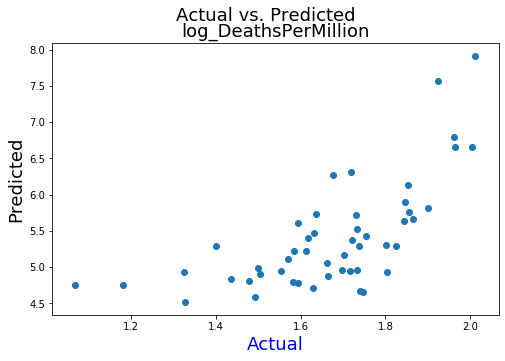

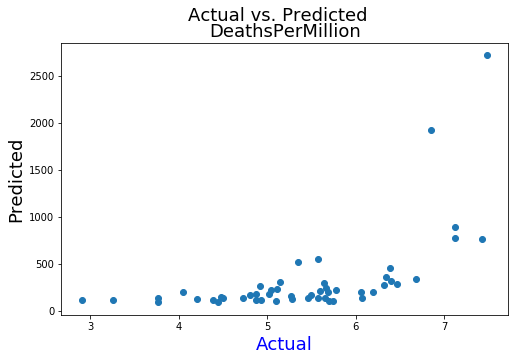

In [60]:
# Make predictions 
pred_m2 = result1.predict(X_)

plt.figure(figsize=(8,5))
plt.suptitle("Actual vs. Predicted ",fontsize=18)
plt.title("log_DeathsPerMillion",fontsize=18)
plt.xlabel("Actual",fontsize=18, color="blue")
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=np.log(y_m2),y=pred_m2)
plt.show()


# Make predictions (CONVERTING THE LOG TRANSFORM BACK TO DEATHS PER MILLION)
pred_m2 = np.exp(result1.predict(X_))

plt.figure(figsize=(8,5))
plt.suptitle("Actual vs. Predicted",fontsize=18)
plt.title("DeathsPerMillion",fontsize=18)
plt.xlabel("Actual",fontsize=18, color="blue")
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_m2,y=pred_m2)
plt.show()

#### Model 2 Interpretation:

<p>The second model (Model 2) used log_DeathsPerMillion as the dependent variable. This model was interesting because fewer variables were significant, so it appears that it is more difficult to predict death rate than it is to predict incident rate given our variable set. In fact, removing variables one at a time, to arrive at a model with only significant variables resulted in a model containing only 3 variables: Population_Density, Med_HHI_thousands, and GDP_Billions.</p>

<p>In a model fit on all 50 states using only the three significant variables, both Population_Density and GDP_Billions have positive coefficients with very small magnitudes (0.0029 and 0.0004 respectively). The coefficient for Med_HHI_thousands (-0.0265), however, has a larger magnitude. Because we log-transformed the dependent variable we can interpret this coefficient to mean that all else being equal, for every thousand-dollar increase in a state's median household income we can expect a 2.7% decrease in deaths per million. That is a valuable insight. The data seems to confirm our intuition that states with less-wealthy residents do not fare as well during the pandemic.  It is also worth noting that when fitting this paired-down model using a train/test split, the training RMSE was 0.686 while the test set RMSE was 0.799.</p>

<p>Because our research question is related to the governor effects on the pandemic outcomes, we did not stop at the paired-down model. We ultimately fit a model on all 50 states using the same seven variables from Model 1. Those model results are listed above in Table 2. The p-values for all variables related to the governor (i.e. Sex_F, Party_Democratic, and Gov_Tenure_at_Onset) are very high (0.878, 0.619, and 0.860 respectively). Therefore, we cannot conclude at this time that the political party of the governor or the governor-related control variables have much of an impact on the COVID-19 death rate in a state. More research would be needed to draw any conclusions about the relationship between a state’s death rate and its governor’s politics and policies. </p>